In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '/Users/mi/Docs/RVU/IML/project/Data In CSV/NewFinal.csv'  # Adjust the path if necessary
df = pd.read_csv(file_path)

In [3]:
print("Dataset Overview:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   12486 non-null  object
 1   Sender    12486 non-null  object
 2   Receiver  12486 non-null  object
 3   Date      12486 non-null  object
 4   Body      12486 non-null  object
dtypes: object(5)
memory usage: 487.9+ KB
None

Missing Values:
 Subject     0
Sender      0
Receiver    0
Date        0
Body        0
dtype: int64


In [4]:
df.dropna(inplace=True)
print("\nDataset after dropping NaN rows:")
print(df.info())


Dataset after dropping NaN rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   12486 non-null  object
 1   Sender    12486 non-null  object
 2   Receiver  12486 non-null  object
 3   Date      12486 non-null  object
 4   Body      12486 non-null  object
dtypes: object(5)
memory usage: 487.9+ KB
None


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Take the [CLS] token embedding

In [7]:
df["embeddings"] = df["Body"].apply(lambda x: get_bert_embedding(str(x)))

In [8]:
X = np.vstack(df["embeddings"].values)

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [10]:
num_clusters = 10  # Adjust based on the dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)

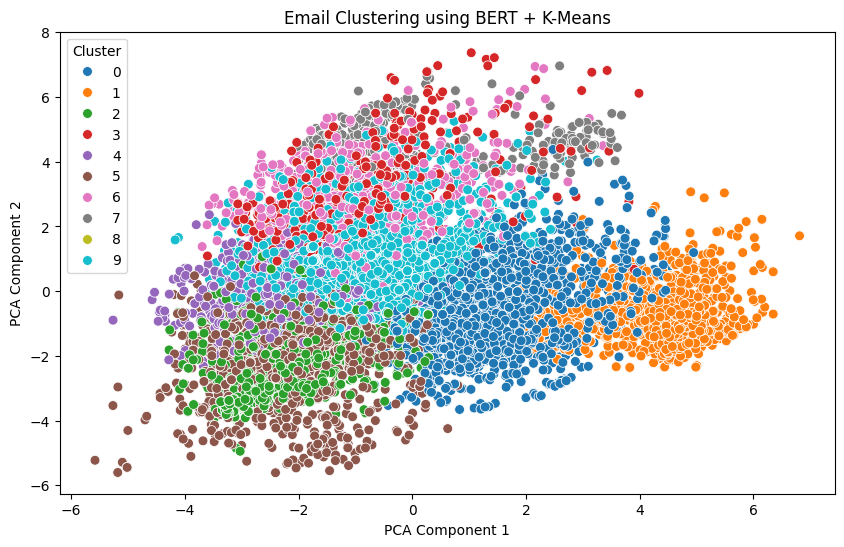

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Cluster"], palette="tab10", s=50)
plt.title("Email Clustering using BERT + K-Means")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [12]:
for i in range(num_clusters):
    print(f"\nCluster {i} Example Emails:\n", df[df["Cluster"] == i][["Subject", "Body"]].head(3))


Cluster 0 Example Emails:
                                             Subject  \
3  Your 2025 Application Update from Shiv Nadar U...   
6  "C J Sakshi C J S, LPU 2025 Application Status...   
8                       Customer Satisfaction Survey   

                                                Body  
3  Shiv Nadar University Chennai 2025 Application...  
6  Lovely Professional University 2025 Applicatio...  
8  Dear Customer,\r\nCanara Bank strive to provid...  

Cluster 1 Example Emails:
                                                 Subject  \
2446  "New announcement: ""Dear students,In the IML ...   
2449  "New announcement: ""Dear Students, Happy Repu...   
2465                          New material: ""Week #2""   

                                                   Body  
2446  Classroom Logo\r\n\tNotification settings\r\nI...  
2449  Classroom Logo\r\n\tNotification settings\r\nC...  
2465  Classroom Logo\r\n\tNotification settings\r\nC...  

Cluster 2 Example Emails:
    

In [13]:
cluster_dict = {}

# Loop through each unique cluster and store emails
for cluster_num in df["Cluster"].unique():
    cluster_dict[f"Cluster {cluster_num}"] = df[df["Cluster"] == cluster_num]["Body"].tolist()

# Find the max length (for padding shorter lists)
max_length = max(len(emails) for emails in cluster_dict.values())

# Pad shorter lists with empty strings
for key in cluster_dict:
    cluster_dict[key] += [""] * (max_length - len(cluster_dict[key]))

# Convert dictionary to a DataFrame
clustered_df = pd.DataFrame(cluster_dict)

# Save to CSV
output_file = "/Users/mi/Docs/RVU/IML/project/Data In CSV/Output_clustered.csv"
clustered_df.to_csv(output_file, index=False)

print(f"Clustered emails saved successfully at: {output_file}")

Clustered emails saved successfully at: /Users/mi/Docs/RVU/IML/project/Data In CSV/Output_clustered.csv


In [14]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [15]:
df.head()

,Subject,Sender,Receiver,Date,Body,embeddings,Cluster
0,Security alert,Google <no-reply@accounts.google.com>,cjsakshi29@gmail.com,2025-02-15,Google\r\nMozilla Thunderbird Email was grante...,"[-0.24771668, -0.07088886, 0.03206096, -0.1651...",2
1,Security alert,Google <no-reply@accounts.google.com>,cjsakshi29@gmail.com,2025-02-15,Google\r\nA new sign-in on Mac\r\n\tcjsakshi29...,"[-0.21824764, 0.0041552037, 0.16178945, -0.003...",2
2,Reminder to attend Wipro Turbo Hiring 2025,Team Unstop <noreply@dare2compete.news>,cjsakshi29@gmail.com,2025-02-15,"C J Sakshi, Wipro Turbo Hiring 2025. ﻿ ͏ ﻿ ͏...","[-0.15016966, -0.38536513, -0.00717593, -0.023...",5
3,Your 2025 Application Update from Shiv Nadar U...,Shiv Nadar University <info@study.selfstudys.com,C J Sakshi C J S <cjsakshi29@gmail.com>,2025-02-15,Shiv Nadar University Chennai 2025 Application...,"[-0.15387304, -0.34320557, 0.20652823, -0.2361...",0
4,Intel is hiring Graphics Software Engineering ...,Team Unstop <noreply@dare2compete.news>,cjsakshi29@gmail.com,2025-02-15,Tap to view details ﻿ ͏ ﻿ ͏ ﻿ ͏ ﻿ ͏ ﻿ ͏ ...,"[0.034503955, -0.21814662, -0.1359399, -0.0760...",5


In [16]:
latest_date = df["Date"].max()
print(f"Latest Date in Dataset: {latest_date}")

Latest Date in Dataset: 2025-02-16 00:00:00


In [17]:
latest_date_DF = df[df["Date"] == latest_date].reset_index(drop=True)

In [18]:
latest_date_DF.to_csv("/Users/mi/Docs/RVU/IML/project/Data In CSV/latest_date_emails.csv", index=False)
print("Latest date emails saved!")

Latest date emails saved!


In [19]:
# Filter emails that are not from the latest date
df_remaining = df[df["Date"] < latest_date].copy()

# Create a 'Month_Year' column
df_remaining["Month_Year"] = df_remaining["Date"].dt.strftime("%B_%Y")

# Group emails by Month_Year
monthly_dfs = {month: group for month, group in df_remaining.groupby("Month_Year")}

# Print available months
print("Available months:", list(monthly_dfs.keys()))

Available months: ['April_2021', 'April_2022', 'April_2023', 'April_2024', 'August_2020', 'August_2021', 'August_2022', 'August_2023', 'August_2024', 'December_2020', 'December_2021', 'December_2022', 'December_2023', 'December_2024', 'February_2021', 'February_2022', 'February_2023', 'February_2024', 'February_2025', 'January_2021', 'January_2022', 'January_2023', 'January_2024', 'January_2025', 'July_2021', 'July_2022', 'July_2023', 'July_2024', 'June_2021', 'June_2022', 'June_2023', 'June_2024', 'March_2021', 'March_2022', 'March_2023', 'March_2024', 'May_2021', 'May_2022', 'May_2023', 'May_2024', 'November_2020', 'November_2021', 'November_2022', 'November_2023', 'November_2024', 'October_2020', 'October_2021', 'October_2022', 'October_2023', 'October_2024', 'September_2020', 'September_2021', 'September_2022', 'September_2023', 'September_2024']


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Define number of clusters
NUM_CLUSTERS = 10  # Adjust based on your data

# Store clustered dataframes
clustered_monthly_dfs = {}

for month, data in monthly_dfs.items():
    print(f"Processing emails for {month}...")

    if len(data) < NUM_CLUSTERS:
        print(f"Skipping {month} as it has only {len(data)} emails, which is less than {NUM_CLUSTERS}.")
        continue  # Skip this month if the number of emails is less than clusters

    # Text vectorization (TF-IDF)
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(data["Body"])

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
    data["Cluster"] = kmeans.fit_predict(X)

    # Save clustered emails
    clustered_monthly_dfs[month] = data

    # Save to CSV (optional)
    data.to_csv(f"/Users/mi/Docs/RVU/IML/project/Data In CSV/months/clustered_{month}.csv", index=False)

print("Clustering complete!")

Processing emails for April_2021...
Skipping April_2021 as it has only 8 emails, which is less than 10.
Processing emails for April_2022...
Processing emails for April_2023...
Processing emails for April_2024...
Processing emails for August_2020...
Processing emails for August_2021...
Processing emails for August_2022...
Processing emails for August_2023...
Processing emails for August_2024...
Processing emails for December_2020...
Skipping December_2020 as it has only 1 emails, which is less than 10.
Processing emails for December_2021...
Processing emails for December_2022...
Processing emails for December_2023...
Processing emails for December_2024...
Processing emails for February_2021...
Skipping February_2021 as it has only 3 emails, which is less than 10.
Processing emails for February_2022...
Processing emails for February_2023...
Processing emails for February_2024...
Processing emails for February_2025...
Processing emails for January_2021...
Skipping January_2021 as it has o

In [ ]:
from transformers import pipeline

# Explicitly specify the model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)  # Use GPU (MPS)

# Function to summarize email bodies
def summarize_text(text):
    if len(text.split()) < 30:  # Skip short texts
        return text
    
    # Truncate long texts to prevent token errors
    truncated_text = " ".join(text.split()[:1000])  # Keep within limit
    
    try:
        summary = summarizer(truncated_text, max_length=100, min_length=30, do_sample=False)
        return summary[0]["summary_text"]
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return text  # Return original if summarization fails

# Apply summarization to the "Body" column
latest_date_DF["Summary"] = latest_date_DF["Body"].apply(summarize_text)

# Save the summarized emails
save_path = "/Users/mi/Docs/RVU/IML/project/Data In CSV/summarized_latest_date.csv"
latest_date_DF.to_csv(save_path, index=False)

print(f"Summarized latest date emails saved at {save_path}!")

In [39]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert sparse matrix to dense array
if hasattr(X, "toarray"):  # If X is sparse, convert it
    X = X.toarray()

# Perform train-test split
X_train, X_test, train_indices, test_indices = train_test_split(
    X, np.arange(X.shape[0]), test_size=0.2, random_state=42
)

# Create train_df and test_df
train_df = df.iloc[train_indices].copy()
test_df = df.iloc[test_indices].copy()


In [36]:
test_df = df.iloc[test_indices].copy()    # Copy only test emails
train_df = df.iloc[train_indices].copy()  # Copy only train emails

NameError: name 'test_indices' is not defined

In [40]:
from sklearn.cluster import KMeans

# Train K-Means on training data
kmeans = KMeans(n_clusters=10, random_state=42)
train_clusters = kmeans.fit_predict(X_train)

# Assign cluster labels to training data
train_df["Cluster"] = train_clusters

In [41]:
test_clusters = kmeans.predict(X_test)

# Assign cluster labels to test data
test_df["Cluster"] = test_clusters


In [42]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Evaluate on training data
sil_train = silhouette_score(X_train, train_clusters)
dbi_train = davies_bouldin_score(X_train, train_clusters)
ch_train = calinski_harabasz_score(X_train, train_clusters)

# Evaluate on test data
sil_test = silhouette_score(X_test, test_clusters)
dbi_test = davies_bouldin_score(X_test, test_clusters)
ch_test = calinski_harabasz_score(X_test, test_clusters)

# Print results
print(f"Silhouette Score - Train: {sil_train}, Test: {sil_test}")
print(f"Davies-Bouldin Index - Train: {dbi_train}, Test: {dbi_test}")
print(f"Calinski-Harabasz Score - Train: {ch_train}, Test: {ch_test}")


Silhouette Score - Train: 0.1067264387297747, Test: 0.11647069983103951
Davies-Bouldin Index - Train: 2.3531996008888796, Test: 2.142133712828975
Calinski-Harabasz Score - Train: 20.08664680493971, Test: 6.178710496364173


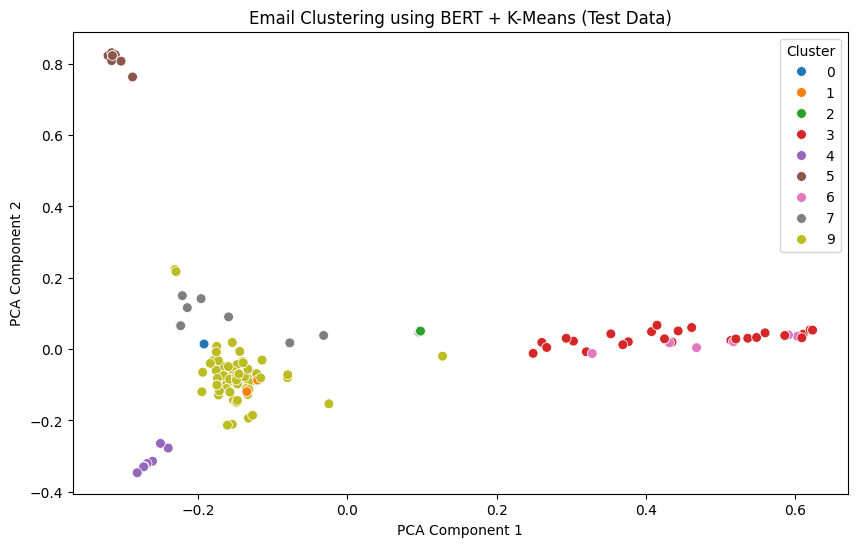

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=test_df["Cluster"], palette="tab10", s=50)
plt.title("Email Clustering using BERT + K-Means (Test Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()
